In [1]:
from thermalmodels_fixedDR import FirstOrderModel
from DR_thermalenvironments_Fix import DirectControlEnv, SetpointDeltaEnv, DirectSetpointEnv

from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN, A2C,PPO2,ACER,TRPO

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
from itertools import cycle
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('combined_csv.csv')

In [4]:
prices = df[["Spot Price ($/MWh)"]]      
prices = np.array(prices)


In [5]:
np.min(prices)

-41.38

In [6]:
policy1 = A2C.load('a2c_2')

Loading a model without an environment, this model cannot be trained until it has a valid environment.





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




In [7]:
policy2 = A2C.load('a2c_3')

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [8]:
from stable_baselines.common.policies import FeedForwardPolicy, register_policy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Custom MLP policy of three layers of size 128 each
class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           net_arch=[dict(pi=[128, 128, 128],
                                                          vf=[256,128,128,128])],
                                           feature_extraction="mlp")

# Register the policy, it will check that the name is not already taken
register_policy('CustomPolicy', CustomPolicy)

In [14]:
#Instantiate the firstorder model
tcl = FirstOrderModel(10*60, 20*60, 21,2,0.2)  # Calling the function firstorder model arg1,2- seconds to heat and seconds to cool, arg3-Goal, flex and noise

env = DirectSetpointEnv(tcl,prices,policy1,policy2)

#model3 = DQN("MlpPolicy", env, verbose=1, exploration_fraction=0.30, exploration_final_eps=0.1,target_network_update_freq=10000,prioritized_replay = True,buffer_size=100000,double_q = True,
           #  seed = 30, tensorboard_log="/floyd/home")    # 
model2 = ACER("MlpPolicy", env, gamma=0.95, verbose=0,seed = 12211,tensorboard_log="/floyd/home/price")
#model = PPO2("MlpPolicy", env, gamma=0.96, verbose=0,tensorboard_log="/floyd/home/fix",seed = 121);
model2.learn(total_timesteps=70000)
#model2.save("default1")

In [15]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

In [36]:
from thermalmodels import FirstOrderModel
from DR_thermalenvironments_price import DirectControlEnv, SetpointDeltaEnv, DirectSetpointEnv

from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN, A2C,PPO2,ACER

In [37]:
tcl = FirstOrderModel(25*60, 35*60, 21,2,0.2)  # Calling the function firstorder model arg1,2- seconds to heat and seconds to cool, arg3-Goal, flex and noise

env = DirectSetpointEnv(tcl,prices,policy1,policy2)

In [38]:
env = DummyVecEnv([lambda: env])

In [16]:
def evaluate(model,env,n_eval_episodes,return_episode_rewards = False,deterministic = True, baseline = False):
    episode_rewards, episode_lengths = [], []
    episode_costs,episode_comforts = [],[]
    for _ in range(n_eval_episodes):
       # if _ == 0:
        obs = env.reset()
        done, state = False, None
        episode_reward = 0.0
        episode_length = 0
        episode_cost = 0.0
        episode_comfort = 0.0
        
        while not done:
            action, state = model.predict(obs, state=state, deterministic=deterministic)
            if baseline:
                obs, reward, done, _info = env.step(21) # Ignore what the policy is predicting always set to 21
                               
            else:
                obs, reward, done, _info = env.step(action)
            episode_reward += reward
            episode_length += 1
            episode_cost += _info['Cost'] #Add up costs 
            episode_comfort += _info['Comfort']
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        episode_costs.append(episode_cost)
        episode_comforts.append(episode_comfort)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    mean_cost = np.mean(episode_costs)
    std_cost = np.std(episode_costs)
    mean_comfort = np.mean(episode_comforts)
    std_comfort = np.std(episode_comforts)
    
    if return_episode_rewards:
        return episode_rewards, episode_lengths
    return mean_reward, std_reward,mean_cost,std_cost,mean_comfort,std_comfort

In [17]:
# Model A2C Policy
tcl = FirstOrderModel(10*60,20*60, 21,2,0.2) 
env = DirectSetpointEnv(tcl,prices,policy1,policy2)
mean_reward, std_reward,sum_cost,std_cost,sum_comfort,std_comfort = evaluate(model2, env, n_eval_episodes=30,baseline = True)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
print(f"total_costs:{sum_cost:.2f} +/- {std_cost:.2f}")
print(f"total_comfort:{sum_comfort:.2f} +/- {std_comfort:.2f}")

mean_reward:273.53 +/- 5.81
total_costs:6.70 +/- 1.60
total_comfort:288.00 +/- 0.00


In [18]:
# Model A2C Policy
tcl = FirstOrderModel(10*60,20*60, 21,2,0.2) 
env = DirectSetpointEnv(tcl,prices,policy1,policy2)
amean_reward, astd_reward,asum_cost,astd_cost,asum_comfort,astd_comfort = evaluate(model2, env, n_eval_episodes=30)
print(f"mean_reward:{amean_reward:.2f} +/- {astd_reward:.2f}")
print(f"total_costs:{asum_cost:.2f} +/- {astd_cost:.2f}")
print(f"total_comfort:{asum_comfort:.2f} +/- {astd_comfort:.2f}")

mean_reward:276.63 +/- 4.81
total_costs:5.71 +/- 1.26
total_comfort:287.62 +/- 0.19


In [15]:
model_new = A2C.load("trans01",tensorboard_log="/floyd/home/trans_t1",seed=100011)

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [18]:
env = DummyVecEnv([lambda: env])
model_new.set_env(env)

In [ ]:
# Model A2C Policy
tcl = FirstOrderModel(22*60,33*60, 21,2,0.2) 
env = DirectSetpointEnv(tcl,prices,policy1,policy2)
amean_reward, astd_reward,asum_cost,astd_cost,asum_comfort,astd_comfort = evaluate(model_new, env, n_eval_episodes=50)
print(f"mean_reward:{amean_reward:.2f} +/- {astd_reward:.2f}")
print(f"total_costs:{asum_cost:.2f} +/- {astd_cost:.2f}")
print(f"total_comfort:{asum_comfort:.2f} +/- {astd_comfort:.2f}")

In [13]:
for i in price3:
    if i > 80:
        print(i)

In [22]:
obs = env.reset()

In [23]:
obs = [18.85872821, 18         ,38.50959   ]

In [10]:
seconds3 = []
price3 = []
reward3 = []
temp3 = []
setpoint3 = []
times = []
comf = []
obs = env.reset()
dones = False
#while not dones:
for i in range(2000):
    action, _states = model2.predict(obs)
   
    obs, rewards, dones, info = env.step(action)
    
    seconds3.append(info['SecondsON'])
    setpoint3.append((info['Action']/2) + 10)
    reward3.append(rewards)
    times.append(i)
    temp3.append(obs[0])
    comf.append(info['Comfort'])
    price3.append(info['Price'])
 #   print(obs[0],rewards,info)
   # env.render(mode='human')

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

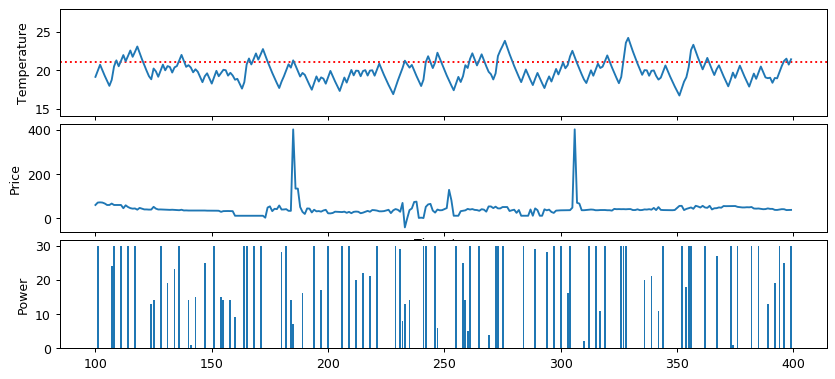

In [13]:
### Plot the resulting temperature trajectory.
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(11,5), dpi=90)
plt.subplots_adjust(hspace=0.075) # Reduce space between plots
#ax1.axvspan(60, 66, facecolor='0.95') # Shade the demand-response times with grey background
#ax1.axvspan(200, 206, facecolor='0.95')

#ax2.axvspan(60, 66, facecolor='0.85') # Shade the demand-response times with grey background
#ax2.axvspan(200, 206, facecolor='0.85')

ax1.axhline(y=21, linestyle=':', color='red') # Plot the goal temperature
ax1.plot(times[100:400], temp3[100:400]) # Plot the observed temperatures
ax1.set_ylabel('Temperature')
ax1.set_ylim(14,28)
ax2.plot(times[100:400], price3[100:400]) # Plot the activations on a separate axis.
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Price');
ax3.bar(times[100:400],seconds3[100:400])
ax3.set_ylabel('Power');

In [11]:
min(reward3),max(reward3)

(-1, 1.0)

In [28]:
X=np.array(reward3).reshape(1,-1)

In [37]:
X.shape

(1, 20000)

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
scaler = MinMaxScaler()
print(scaler.fit(X))
print(scaler.data_max_)


MinMaxScaler(copy=True, feature_range=(0, 1))
[0.9990471  0.99179011 0.9727609  ... 0.99390729 0.99991515 1.        ]


In [20]:
a = scaler.transform(X)

In [43]:
params = scaler.get_params(deep=True)

In [44]:
scaler_2 = MinMaxScaler()

In [46]:
scaler_2.set_params(params[0])

KeyError: 0

In [40]:
a

array([[0.99952355],
       [0.99589506],
       [0.98638045],
       ...,
       [0.99695364],
       [0.99995758],
       [1.        ]])

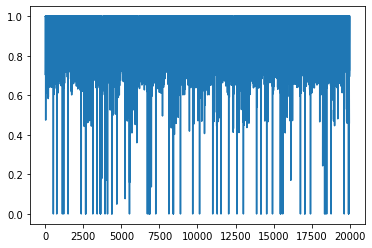

In [41]:
plt.plot(a)

In [24]:
X_std = (X - min(reward3)) / (max(reward3) - min(reward3))
X_scaled = X_std * (0 - 1) + 0

In [25]:
X_scaled

array([[-0.99952355],
       [-0.99589506],
       [-0.98638045],
       ...,
       [-0.99695364],
       [-0.99995758],
       [-1.        ]])

In [11]:
reward3.index(min(reward3))

9069

In [12]:
print(seconds3[6],setpoint3[6],reward3[6],comf[6],price3[6])

17 29.5 0.846319278684096 0.5089127070498086 40.99138


NameError: name 'temps' is not defined

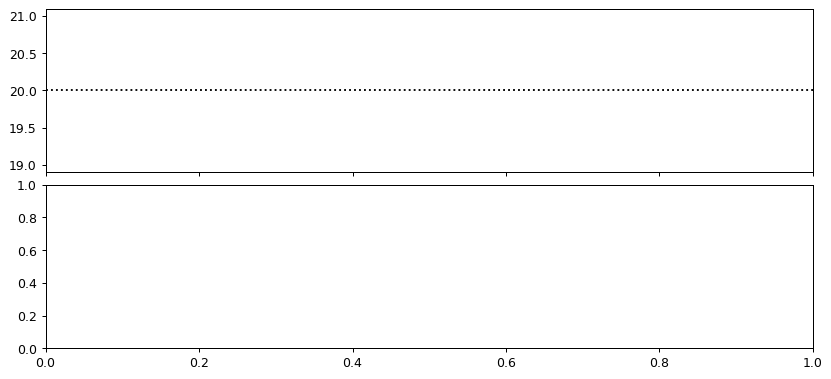

In [44]:
### Plot the resulting temperature trajectory.
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(11,5), dpi=90)
plt.subplots_adjust(hspace=0.075) # Reduce space between plots
#ax1.axvspan(start, start+length, facecolor='0.95') # Shade the demand-response times with grey background
ax1.axhline(y=20, linestyle=':', color='black') # Plot the goal temperature
ax1.plot(times, temps) # Plot the observed temperatures
ax1.set_ylabel('Temperature')
ax1.set_ylim(17.5,22.5)
ax2.bar(times, uses) # Plot the activations on a separate axis.
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Power');